# Introduction

The notebook contains a solution to the binary classification problem, based on a dataset available under [this link](https://archive.ics.uci.edu/ml/machine-learning-databases/00267/). The idea of the task was to distinguish genuine and forged banknotes based on certain features of their images. 

The provided solution served as an example to test and present a few of the most important performance metrics for binary classifiers. Stochastic gradient descent classifier was used.

The code was based on Chapter 3 of Aurelien Geron, 'Hands - On Machine Learing with Scikit-Learn and TensorFlow', Helion SA, 2018. 

In [1]:
import os
from six.moves import urllib
import tarfile
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
DOWNLOAD_ROOT = 'http://archive.ics.uci.edu/ml/machine-learning-databases/'
BANKNOTE_PATH = os.path.join('datasets', 'banknotes')
BANKNOTE_URL = DOWNLOAD_ROOT + '00267/data_banknote_authentication.txt'

def fetch_data(data_url, data_path, filename, is_tar = False):
    if  not os.path.isdir(data_path):
        os.makedirs(data_path)
    file_path = os.path.join(data_path, filename)
    urllib.request.urlretrieve(data_url, file_path)
    if is_tar:
        with tarfile.TarFile(file_path) as current_tar:
            current_tar.extractall(data_path)

def load_data(data_path, filename, separator = ",", header = None):
    file_path = os.path.join(data_path, filename)
    return pd.read_csv(file_path, sep = separator, header = header)

In [3]:
fetch_data(BANKNOTE_URL, BANKNOTE_PATH, 'banknote_data.txt')
banknote_raw_data = load_data(BANKNOTE_PATH, 'banknote_data.txt')

names = ['1', '2', '3', '4', 'label']

banknote_raw_data.columns = names
banknote_raw_data.head()

,1,2,3,4,label
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
banknote_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
1        1372 non-null float64
2        1372 non-null float64
3        1372 non-null float64
4        1372 non-null float64
label    1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [5]:
banknote_raw_data.describe()

,1,2,3,4,label
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


The data set is complete (there are no missing values) and consists of 4 features, represented by 64-bit floating point numbers, alongside a binary label, indicating a class to which the example belongs to. The histograms are visualized in order to find basic information about the distribution of each feature's values. In the next step, the data is shuffled and split into training and test set, in a way to ensure equal distribution of each class' examples in both sets. The standarization of data set is achieved with StandardScaler class, which is a part of scikit-learn library.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff442ded320>,
      dtype=object)

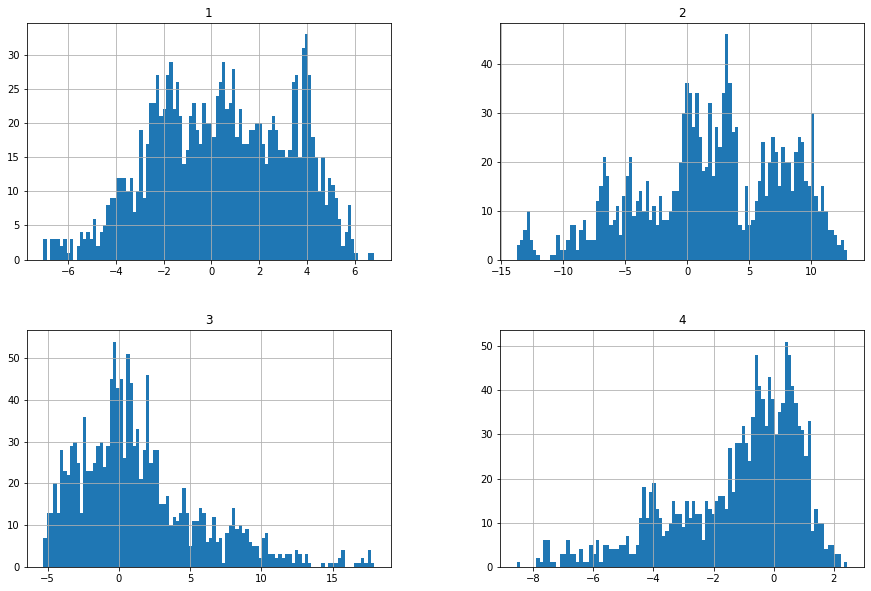

In [75]:
banknote_raw_data.hist(column = ['1', '2', '3', '4'], bins = 100, figsize = (15, 10))

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(banknote_raw_data, banknote_raw_data['label']):
    strat_train_set = banknote_raw_data.loc[train_index]
    strat_test_set = banknote_raw_data.loc[test_index]
    
print(banknote_raw_data['label'].value_counts() / len(banknote_raw_data))
print('\n')
print(strat_train_set['label'].value_counts() / len(strat_train_set))

0    0.555394
1    0.444606
Name: label, dtype: float64


0    0.55515
1    0.44485
Name: label, dtype: float64


In [22]:
train_data = strat_train_set.copy()

shuffle_indexes = np.random.permutation(len(train_data))
train_data = train_data.iloc[shuffle_indexes]
train_data = train_data.reset_index(drop = True)

targets = train_data['label']
data = train_data.drop('label', axis = 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff444d23128>,
      dtype=object)

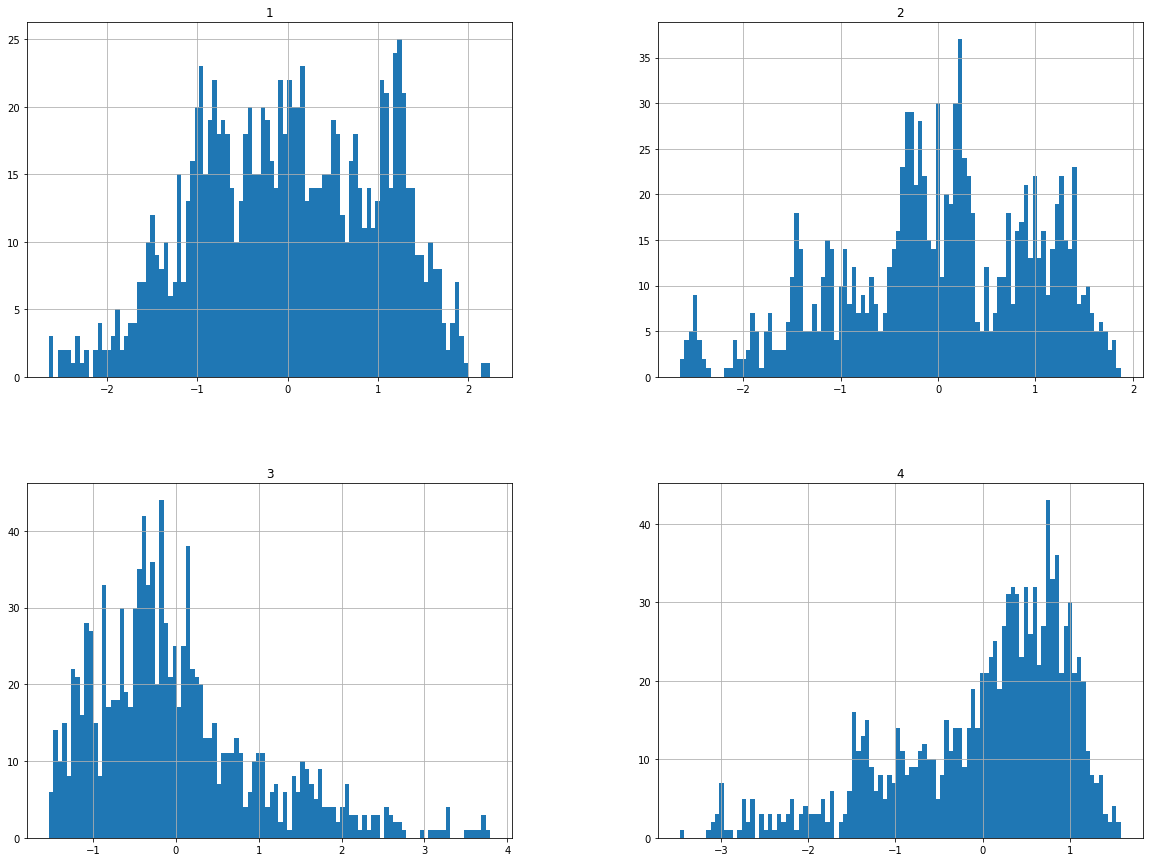

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

data_scaled = pd.DataFrame(data = data_scaled[:,:],
                           index = None,
                           columns = ['1', '2', '3', '4'])

data_scaled.hist(bins = 100, figsize = (15, 10))

Stochastic gradient descent classification algorithm is implemented in scikit-learn as SGDClassifier class. The model was trained with the train set, which consists of 1097 examples from the input set.
### Basic numeric metrics

Firstly, the fit is evaluated with a confusion matrix, precision and recall score and F1 score.

In [64]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state = 42)
sgd_classifier.fit(data_scaled, targets)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [65]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

data_predict = cross_val_predict(sgd_classifier, data_scaled, targets, cv = 3)
confusion_matrix(targets, data_predict)

array([[602,   7],
       [  7, 481]])

In [66]:
from sklearn.metrics import precision_score, recall_score

print('Precision of predictions: ', precision_score(targets, data_predict))
print('Recall of predictions: ', recall_score(targets, data_predict))

Precision of predictions:  0.985655737704918
Recall of predictions:  0.985655737704918


In [67]:
from sklearn.metrics import f1_score

print('F1 score: ', f1_score(targets, data_predict))

F1 score:  0.985655737704918


### Precision - recall curve

The next metric used to evaluate the fit was a precision - recall curve. Firstly, the curve was plotted as a function of a threshold of a decision function. Based on tha graph, the threshold was calculated to ensure the optimal relationship between precision and recall scores. Of course, depending on the project's requirements, that value can be increased or lowered to put greater importance on one of the scores. A 3-fold cross - validation test was used.

Secondly, the curve was plotted as precision in a function of recall.

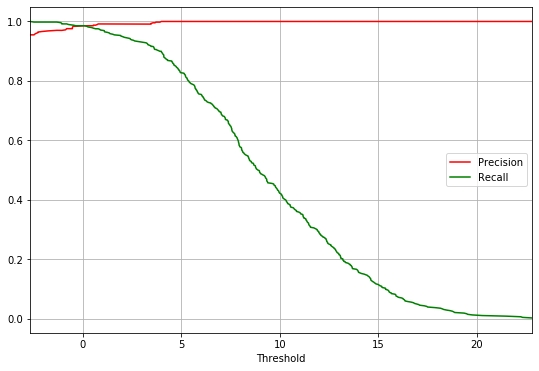

Threshold for maximum values of precision and recall:  0.09451522975041904


In [68]:
from sklearn.metrics import precision_recall_curve

data_pred_scores = cross_val_predict(sgd_classifier, data_scaled, targets, cv = 3, 
                                     method = 'decision_function')
precs, recalls, thresh = precision_recall_curve(targets, data_pred_scores)

plt.figure(figsize = (9, 6))
plt.plot(thresh, precs[:-1], 'r-', label = "Precision")
plt.plot(thresh, recalls[:-1], 'g-', label = "Recall")
plt.xlabel('Threshold')
plt.xlim([thresh[np.where(recalls == 1)], thresh[np.where(recalls == 0)[-1] - 1]])
plt.legend(loc = 'center right')
plt.grid(True)
plt.show()

print('Threshold for maximum values of precision and recall: ', thresh[np.where(recalls == precs)][0])

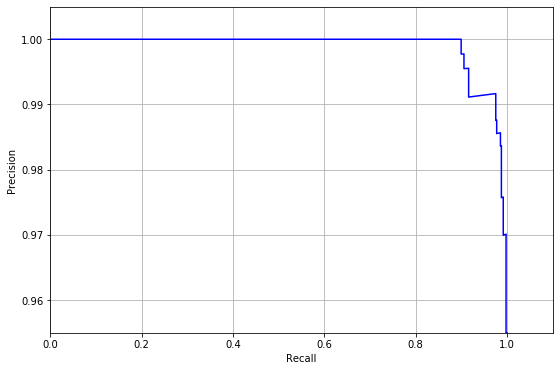

In [70]:
plt.figure(figsize = (9, 6))
plt.plot(recalls[:-1], precs[:-1], 'b')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1.1])
plt.ylim([precs[np.where(recalls == 1)][-1], 1.005])
plt.grid(True)
plt.show()

### ROC Curve

Lastly, the ROC curve was obtained. The area under curve was calculated with scikit - learn library's method. 

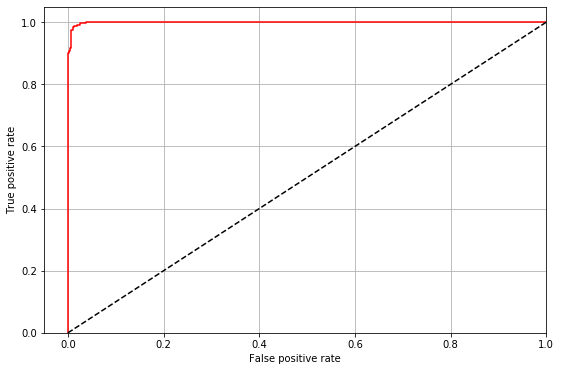

AUC score:  0.9991150502032357


In [71]:
from sklearn.metrics import roc_curve, roc_auc_score

false_positive_rates, true_positive_rates, thresh_roc = roc_curve(targets, data_pred_scores)

plt.figure(figsize = (9,6))
plt.plot(false_positive_rates, true_positive_rates, 'r')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])
plt.grid(True)
plt.show()

print('AUC score: ', roc_auc_score(targets, data_pred_scores))

Finally, the evaluated SGD model was applied to the test set. A confusion matrix, precision and recall scores and F1 score was calculated.

In [74]:
test_data = strat_test_set.copy()

shuffle_indexes_test = np.random.permutation(len(test_data))
test_data = train_data.iloc[shuffle_indexes_test]
test_data = train_data.reset_index(drop = True)

data_test = strat_test_set.drop("label", axis = 1)
targets_test = strat_test_set["label"]

data_test_scaled = scaler.transform(data_test)

data_test_scaled = pd.DataFrame(data = data_test_scaled[:,:],
                                index = None,
                                columns = ['1', '2', '3', '4'])

data_test_predict = cross_val_predict(sgd_classifier, data_test_scaled, targets_test, cv = 3)

print('Confusion matrix for the test set: \n', confusion_matrix(targets_test, data_test_predict))  
print('Precision of predictions for the test set: ', precision_score(targets_test, data_test_predict))
print('Recall of predictions for the test set: ', recall_score(targets_test, data_test_predict))
print('F1 score for the test set: ', f1_score(targets_test, data_test_predict))

Confusion matrix for the test set: 
 [[150   3]
 [  8 114]]
Precision of predictions for the test set:  0.9743589743589743
Recall of predictions for the test set:  0.9344262295081968
F1 score for the test set:  0.9539748953974896


The used model performed very well with the used data set, achieving **the F1 score over 98% for the train set and over 95% for the test set.** 

The practical use of binary classifier's metrics helps to understand the idea behind them and facilitates the further development in the machine learning field.    